In [6]:
import numpy as np
import pandas as pd
import os
import scipy
import scipy.io

import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
# NEED TO UNINSTALL PYEDFLIB, SPECTRUM on this virtual env
import fragility
import fragility.util.utils as util
from datainterface import patient as Pat

import pystan
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

np.random.seed(1234)
%matplotlib inline

In [7]:
def extractdatatoplot(patient, resultsdir, datadir, encoding='ASCII'):
    '''
    This function takes in:
    1. patient name
    2. results directory (perturbation model)
    3. data directory, where all the raw metadata is held
    
    And extracts the data necessary for plotting
    '''
    # files to get resulting data and the original raw data / annotations
    filetoload = os.path.join(resultsdir, patient, patient+'_pertmodel.npz')
    rawdatafile = os.path.join(datadir,  patient, patient+'_rawnpy.npy')
    chanfile =  os.path.join(datadir,  patient, patient + '_chans.csv')
    headerfile = os.path.join(datadir,  patient, patient + '_headers.csv')
    annotationsfile = os.path.join(datadir,  patient, patient + '_annotations.csv')

    ################################ 1. LOAD DATA ###########################
    # instantiate a datainterface object to analyze data
    patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
    # get relevant channel data
    patid, seizid = fragility.util.utils.splitpatient(patient)
    included_chans, onsetchans = fragility.util.utils.returnindices(patid, seizid)
    
    # set metadata to be used in analysis
    patieeg.setincludedchans(included_chans)
    patieeg.setmetadata_fromfile(headersfile=headerfile)
    patieeg.setchannels_fromfile(channelsfile=chanfile)
    patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

    # get the data from files
    data = np.load(filetoload, encoding=encoding)
    
    return patieeg, data, included_chans, onsetchans
def getindicesiwthinlist(labels, ezlabels):
    print(ezlabels)
    print(labels)
    indices = []
    for idx, label in enumerate(labels):
        if label in ezlabels:
            indices.append(idx) 
    return indices

def compute_fragilitymetric(minnormpertmat):
        # get dimensions of the pert matrix
        N, T = minnormpertmat.shape
        
        fragilitymat = np.zeros((N, T))
        for icol in range(T):
            fragilitymat[:,icol] = (np.max(minnormpertmat[:,icol]) - minnormpertmat[:,icol]) /\
                                    np.max(minnormpertmat[:, icol])
                
        return fragilitymat

def compute_minmaxfragilitymetric(minnormpertmat):
    # get dimensions of the pert matrix
    N, T = minnormpertmat.shape

    minmax_fragilitymat = np.zeros((N, T))

    # get the min/max for each column in matrix
    minacrosstime = np.min(minnormpertmat, axis=0)
    maxacrosstime = np.max(minnormpertmat, axis=0)

    # normalized data with minmax scaling
    minmax_fragilitymat = -1 * np.true_divide((minnormpertmat - np.matlib.repmat(maxacrosstime, N, 1)), \
                            np.matlib.repmat(maxacrosstime - minacrosstime, N, 1))

    return minmax_fragilitymat

In [8]:
# rawdatafile and processed data files
resultsdir = '/Volumes/ADAM LI/pydata/output/pert/'
datadir = os.path.join('/Volumes/ADAM LI/pydata/converted/')

print(resultsdir)
print(datadir)

### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'34', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}

/Volumes/ADAM LI/pydata/output/pert/
/Volumes/ADAM LI/pydata/converted/


INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


changed
pt1sz2
Getting the offset indices
{'AD1', 'PD3', 'PD4', 'AD2', 'AD3', 'ATT1', 'PD2', 'AD4', 'PD1', 'ATT2'}
['G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'G8' 'G9' 'G10' 'G13' 'G14' 'G15'
 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G11' 'G12' 'G24' 'G25'
 'G26' 'G27' 'G28' 'G29' 'G30' 'G31' 'G32' 'ATT1' 'ATT2' 'ATT3' 'ATT4'
 'ATT5' 'ATT6' 'ATT7' 'ATT8' 'PLT1' 'PLT2' 'PLT3' 'PLT4' 'PLT5' 'PLT6'
 'AST1' 'AST2' 'AST3' 'AST4' 'PST1' 'PST2' 'PST3' 'PST4' 'AD1' 'AD2' 'AD3'
 'AD4' 'PD1' 'PD2' 'PD3' 'PD4' 'SF1' 'SF2' 'SF3' 'SF4' 'SF5' 'SF6' 'IF1'
 'IF2' 'IF3' 'IF4' 'IF5' 'IF6' 'ILT1' 'ILT2' 'ILT3' 'ILT4' 'MLT1' 'MLT2'
 'MLT3' 'MLT4' 'SLT1' 'SLT2' 'SLT3' 'SLT4']


INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


changed
changed
pt1sz3
Getting the offset indices
{'AD1', 'PD3', 'PD4', 'AD2', 'AD3', 'ATT1', 'PD2', 'AD4', 'PD1', 'ATT2'}
['G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'G8' 'G9' 'G10' 'G13' 'G14' 'G15'
 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G11' 'G12' 'G24' 'G25'
 'G26' 'G27' 'G28' 'G29' 'G30' 'G31' 'G32' 'ATT1' 'ATT2' 'ATT3' 'ATT4'
 'ATT5' 'ATT6' 'ATT7' 'ATT8' 'PLT1' 'PLT2' 'PLT3' 'PLT4' 'PLT5' 'PLT6'
 'AST1' 'AST2' 'AST3' 'AST4' 'PST1' 'PST2' 'PST3' 'PST4' 'AD1' 'AD2' 'AD3'
 'AD4' 'PD1' 'PD2' 'PD3' 'PD4' 'SF1' 'SF2' 'SF3' 'SF4' 'SF5' 'SF6' 'IF1'
 'IF2' 'IF3' 'IF4' 'IF5' 'IF6' 'ILT1' 'ILT2' 'ILT3' 'ILT4' 'MLT1' 'MLT2'
 'MLT3' 'MLT4' 'SLT1' 'SLT2' 'SLT3' 'SLT4']


INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


changed
changed
pt1sz4
Getting the offset indices
{'AD1', 'PD3', 'PD4', 'AD2', 'AD3', 'ATT1', 'PD2', 'AD4', 'PD1', 'ATT2'}
['G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'G8' 'G9' 'G10' 'G13' 'G14' 'G15'
 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G11' 'G12' 'G24' 'G25'
 'G26' 'G27' 'G28' 'G29' 'G30' 'G31' 'G32' 'ATT1' 'ATT2' 'ATT3' 'ATT4'
 'ATT5' 'ATT6' 'ATT7' 'ATT8' 'PLT1' 'PLT2' 'PLT3' 'PLT4' 'PLT5' 'PLT6'
 'AST1' 'AST2' 'AST3' 'AST4' 'PST1' 'PST2' 'PST3' 'PST4' 'AD1' 'AD2' 'AD3'
 'AD4' 'PD1' 'PD2' 'PD3' 'PD4' 'SF1' 'SF2' 'SF3' 'SF4' 'SF5' 'SF6' 'IF1'
 'IF2' 'IF3' 'IF4' 'IF5' 'IF6' 'ILT1' 'ILT2' 'ILT3' 'ILT4' 'MLT1' 'MLT2'
 'MLT3' 'MLT4' 'SLT1' 'SLT2' 'SLT3' 'SLT4']


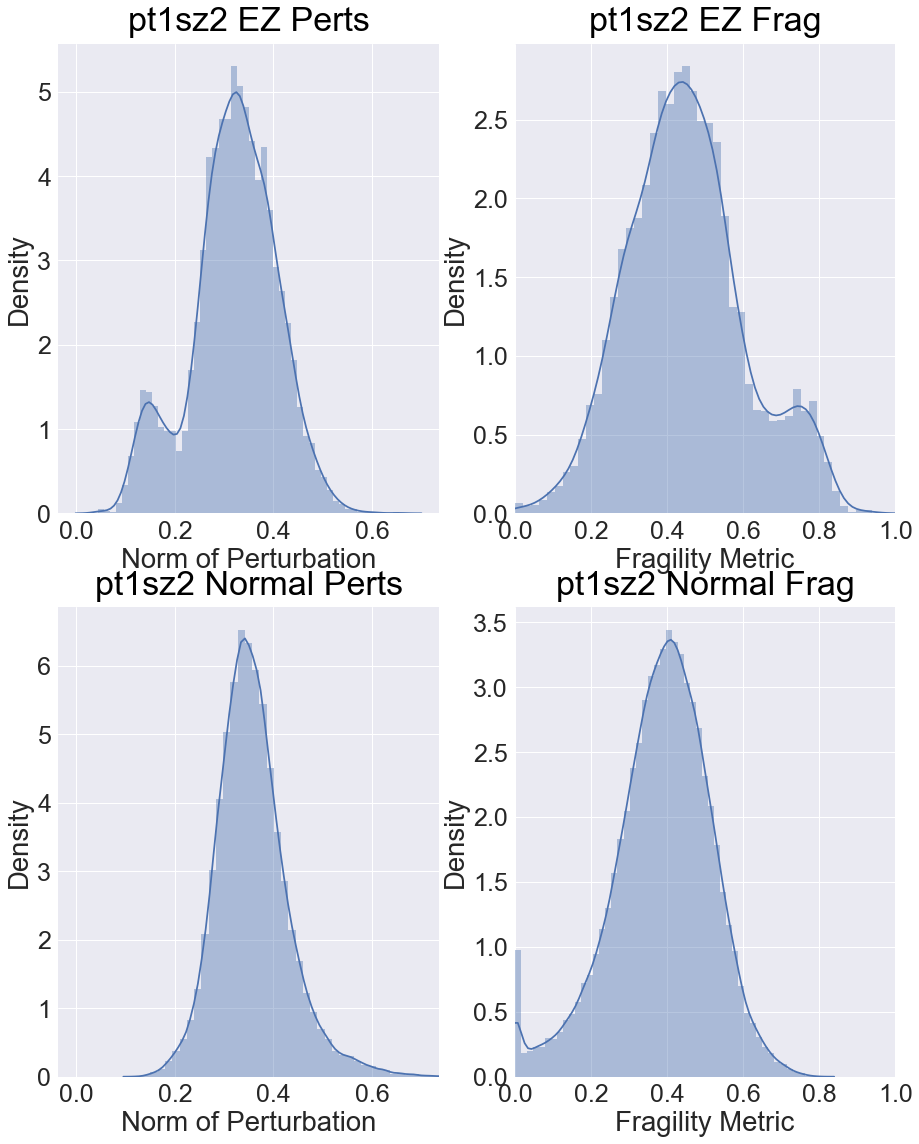

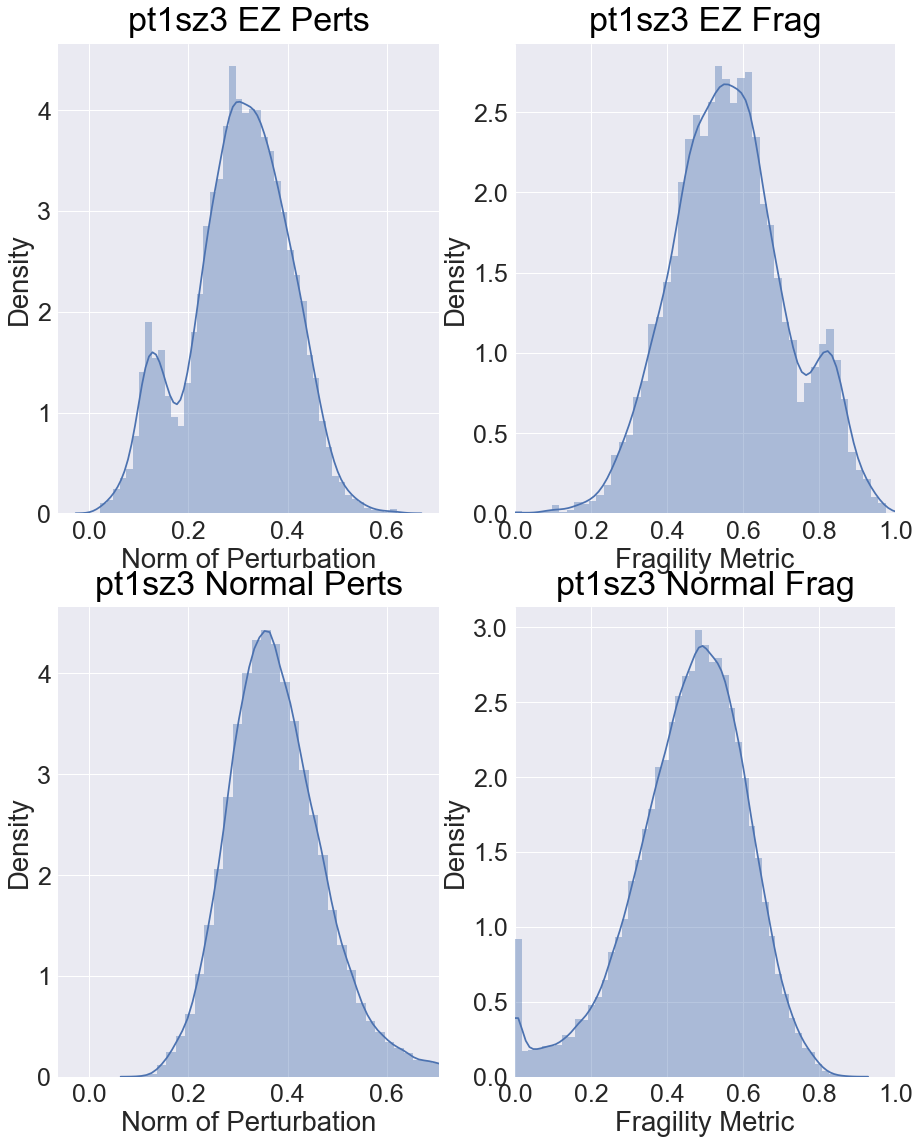

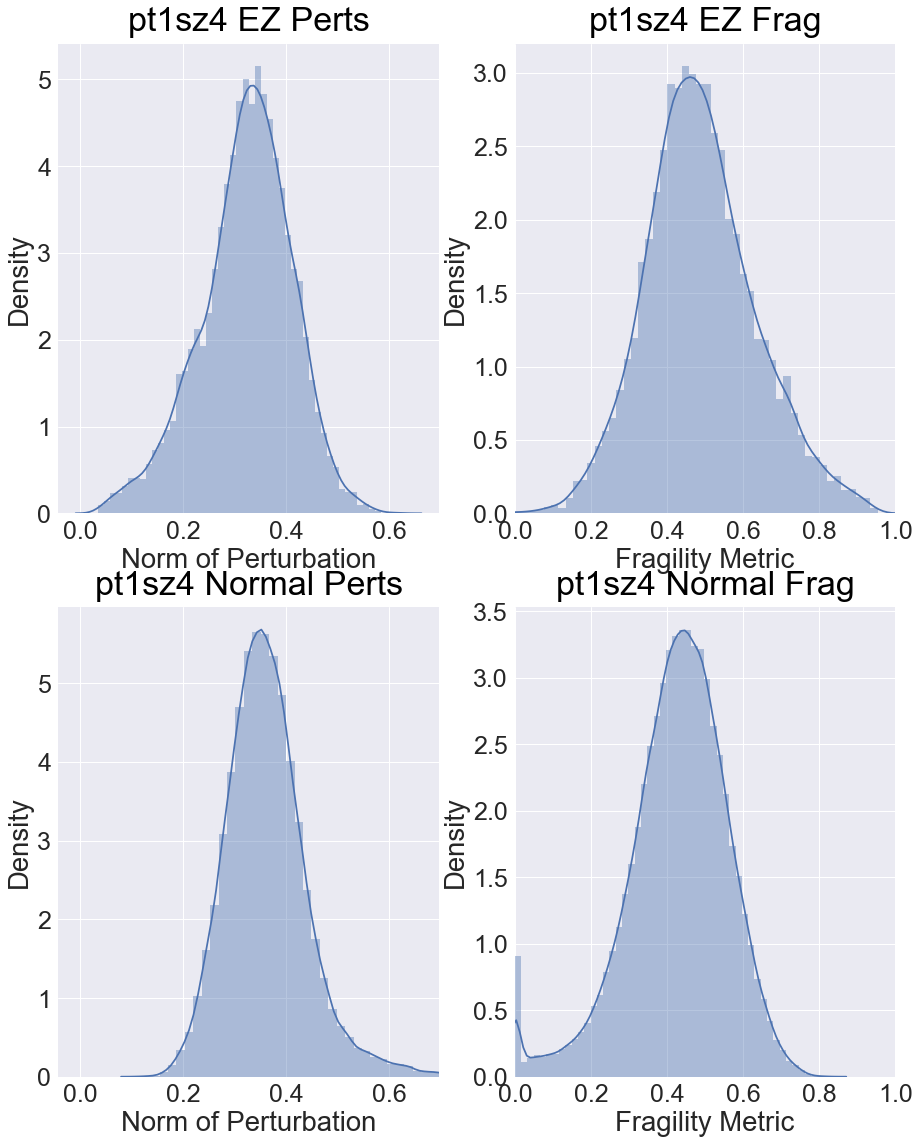

In [37]:
patients = [
            'pt1sz2', 'pt1sz3', 'pt1sz4'
#             'la01_ictal', 'la01_inter', 'la01_inter_2',
#             'la02_ictal', 'la02_inter',
#             'la03_ictal', 'la03_inter',
#             'la04_ictal', 'la04_inter',
#             'la05_ictal', 'la05_inter',
#             'la06_ictal', 'la06_inter',
#             'la07_ictal', 'la07_inter',
#             'la08_ictal', 'la08_inter',
#             'la09_ictal', 'la09_inter',
#             'la10_ictal', 'la10_inter',
#             'la11_ictal', 'la11_inter',
#             'la12_ictal',
#             'la13_ictal', 'la13_inter',
#             'la15_ictal', 'la15_inter',
#             'la16_ictal', 'la16_inter',
#             'la17_ictal', 
           ]
# patient='la01_ictal'

for patient in patients:
    # extract data for this patient 
    patieeg, data, included_chans, onsetchans = extractdatatoplot(patient, resultsdir, datadir, encoding='bytes')

    pertmats = data['pertmats']    
    metadata = data['metadata'].item()
    metadata = {k.decode("utf-8"): (v.decode("utf-8") if isinstance(v, bytes) else v) for k,v in metadata.items()}
    
    timepoints = metadata['timepoints']
    included_chans = metadata['includedchans']
    chanlabels = patieeg.chanlabels[included_chans]
    
#     print(patieeg.chanlabels)
#     print(included_chans)

    onset_indice = []
    offset_indice = []
    # determine the indices to plot onset/offset if they exist
    print(patient)
#     print(metadata.keys())
#     print(included_chans)
#     print(patieeg.onset_time)
#     print(patieeg.offset_time)
    if patieeg.onset_time: 
        onset_indice = fragility.util.utils.converttimestowindow(timepoints, patieeg.onset_time * patieeg.samplefreq)

    if patieeg.offset_time:
        print("Getting the offset indices")
        offset_indice = fragility.util.utils.converttimestowindow(timepoints, patieeg.offset_time * patieeg.samplefreq)

    allindices = range(0,len(chanlabels))
    ezindices = getindicesiwthinlist(chanlabels, onsetchans)
    normindices = list(set(allindices) - set(ezindices))
    
    # Compute the fragility mat
    fragilitymat = compute_fragilitymetric(pertmats)   

    sns.set(font_scale=2.5)
    # plot histograms of model at different time windows
    fig = plt.figure(figsize=(15,19))
    
    timetoplot = np.arange(0,onset_indice[0])#onset_indice[0]-5,onset_indice[0])
#     pertmats = lambda timetoplot
    
    # begin plotting across time perturbation/fragility
    toplot = pertmats[np.ix_(ezindices, timetoplot)].ravel()
    a_pert = plt.subplot(2,2,1)
    ax = sns.distplot(toplot, axlabel='Norm of Perturbation')
    a_pert.set_title(patient + ' EZ Perts', **title_font)
    pert_xlim = list(a_pert.get_xlim())
    ax.set_ylabel('Density')
    
    toplot = fragilitymat[np.ix_(ezindices, timetoplot)].ravel()
    b_frag = plt.subplot(2,2,2)
    ax = sns.distplot(toplot, axlabel='Fragility Metric')
    b_frag.set_xlim(0,1)
    b_frag.set_title(patient + ' EZ Frag', **title_font)
    ax.set_ylabel('Density')
    
    toplot = pertmats[np.ix_(normindices, timetoplot)].ravel()
    c_pert = plt.subplot(2,2,3)
    ax = sns.distplot(toplot, axlabel='Norm of Perturbation')
    c_pert.set_title(patient + ' Normal Perts', **title_font)
    ax.set_ylabel('Density')
    pert_xlim[0] = np.min([a_pert.get_xlim()[0], pert_xlim[0]])
    pert_xlim[1] = np.max([a_pert.get_xlim()[1], pert_xlim[1]])
    
    toplot = fragilitymat[np.ix_(normindices, timetoplot)].ravel()
    d_frag = plt.subplot(2,2,4)
    ax = sns.distplot(toplot, axlabel='Fragility Metric')
    d_frag.set_xlim(0,1)
    d_frag.set_title(patient + ' Normal Frag', **title_font)
    ax.set_ylabel('Density')
    
    # reset perturbation xlim
    a_pert.set_xlim(pert_xlim)
    c_pert.set_xlim(pert_xlim)
    
    # begin plotting Perturbation/Fragility Across Channel Sets = {EZ,Norm}
#     toplot = pertmats[ezindices].ravel()
#     a_pert = plt.subplot(2,2,1)
#     ax = sns.distplot(toplot, axlabel='Norm of Perturbation')
#     a_pert.set_title(patient + ' EZ Perts', **title_font)
#     ax.set_ylabel('Density')
    
#     toplot = fragilitymat[ezindices].ravel()
#     b_frag = plt.subplot(2,2,2)
#     ax = sns.distplot(toplot, axlabel='Fragility Metric')
#     b_frag.set_xlim(0,1)
#     b_frag.set_title(patient + ' EZ Frag', **title_font)
#     ax.set_ylabel('Density')
    
#     toplot = pertmats[normindices].ravel()
#     c_pert = plt.subplot(2,2,3)
#     ax = sns.distplot(toplot, axlabel='Norm of Perturbation')
#     c_pert.set_title(patient + ' Normal Perts', **title_font)
#     ax.set_ylabel('Density')
    
#     toplot = fragilitymat[normindices].ravel()
#     d_frag = plt.subplot(2,2,4)
#     ax = sns.distplot(toplot, axlabel='Fragility Metric')
#     d_frag.set_xlim(0,1)
#     d_frag.set_title(patient + ' Normal Frag', **title_font)
#     ax.set_ylabel('Density')


In [36]:
print(type(pert_xlim))
print(onset_indice)
# print(str(5:10))
# print(ezindices)
# print(type(ezindices))
# print(type(timetoplot))
# test=pertmats[ezindices,]

<class 'tuple'>
[606]


In [34]:
print(pert_xlim)

(-0.036672918986741326, 0.7356448599800425)
